# Compare SMIRFF vs parm@frosst

For a specified set of molecules for which we already have (or can easily generate) parm@frosst parameters in AMBER format, compare single-point energies for the molecules from a specified SMIRFF with those from parm@frosst parameters. This also attempts to do a detailed breakdown of energy differences by force type, and then drill down to find specific atom indices involved in the forces for which there are substantial differences.

This is to address this issue as raised on GitHub: https://github.com/open-forcefield-group/smarty/issues/123

**Major steps**:
1. Obtain set of molecules
2. Obtain parm@frosst parameters for these molecules (current options only AlkEthOH (this repo) or the ZINC test sets from http://www.ccl.net/cca/data/parm_at_Frosst/ ). MMFF94 is also available there but the atom types file appears to be corrupted (has too few entires) and cannot be used.
3. Evaluate energies for all molecules from both sets of parameters in OpenMM
   1. Get total energy comparison
   2. Compare breakdown by force type
   3. Compare breakdown by specific atoms
   

## 1. Obtain set(s) of molecules

We'll use the ZINC (and later, MMFF94) subsets from the CCL link above. These were already downloaded into this directory from that site. Some supplemental files were provided by Christopher Bayly.

### 1.A. Prep molecule sets



In [1]:
# Imports
import openeye.oechem as oechem
import os
from tleap_tools import *
import simtk.unit as unit

# Start with zinc set
# Load with TRIPOS names
infile = 'zinc-subset-tripos.mol2.gz' # Provided by C Bayly and stored here.
istream = oechem.oemolistream(infile)
mol = oechem.OEMol()
oemols_tripos = []
while oechem.OEReadMolecule(istream, mol):
    oemols_tripos.append(oechem.OEMol(mol))
istream.close()
    
# Load with parm@frosst names
infile = 'zinc-subset-parm@frosst.mol2.gz'
flavor = oechem.OEIFlavor_Generic_Default | oechem.OEIFlavor_MOL2_Default | oechem.OEIFlavor_MOL2_Forcefield
istream = oechem.oemolistream(infile)
istream.SetFlavor( oechem.OEFormat_MOL2, flavor)
mol = oechem.OEMol()
oemols_frosst = []
while oechem.OEReadMolecule(istream, mol):
    oemols_frosst.append(oechem.OEMol(mol))
istream.close()

print("%s molecules found" % len(oemols_tripos))

    

7505 molecules found


## 2. Obtain parm@frosst parameters for these molecules if not already available

We either (a) already have these molecules parameterized in the repo (if we've done this before) or we need to generate them by going through tleap and parameterizing. In either case we need to actually have the parameter files sitting here to proceed to the next step, so here we'll do that.

In [2]:
# If we already have the parameters in an archive file, just extract
if os.path.isfile('zinc_frosst_amber.tar.gz') and not os.path.isdir('zinc_frosst_amber'):
    os.system('tar -xvf zinc_frosst_amber.tar.gz')
    file = open('zinc_frosst_amber/failed_idxs.txt', 'r')
    text = file.readlines()
    failed_idxs = [ int(line.split()[0].strip()) for line in text ]
    file.close()
elif os.path.isdir('zinc_frosst_amber'):
    file = open('zinc_frosst_amber/failed_idxs.txt', 'r')
    text = file.readlines()
    failed_idxs = [ int(line.split()[0].strip()) for line in text ]
    file.close()
    
# Otherwise we have to generate
else:
    # Do directory bookkeeping
    mol2dir = 'zinc_frosst_mol2'
    amberdir = 'zinc_frosst_amber'
    os.system('rm -r %s' % mol2dir)
    os.system('rm -r %s' % amberdir)
    os.mkdir(mol2dir)
    os.mkdir(amberdir)
    
    # Generate molecule IDs
    molids = ['zinc%d' %nr for nr in range(len(oemols_tripos))]
    
    # Make parm@frosst mol2 files for each individual molecule
    for (idx, mol) in enumerate(oemols_frosst):
        ostream = oechem.oemolostream(os.path.join(mol2dir, molids[idx]+'.mol2'))
        ostream.SetFlavor( oechem.OEFormat_MOL2, flavor)
        oechem.OEWriteMolecule(ostream, mol)
    
    # parameterize using tleap, parm99, and files provided with parm@frosst from CCL
    frcmod = 'parm_at_Frosst/parm_Frosst.frcmod'
    failed_idxs = []
    for (idx, molid) in enumerate(molids):
        mol2file = os.path.join( mol2dir, molids[idx]+'.mol2')
        prmtop = os.path.join( amberdir, molids[idx]+'.prmtop')
        crd = os.path.join( amberdir, molids[idx]+'.crd')
        print("Setting up %s..." % molid)
        startdir = os.getcwd()
        try:
            run_tleap( molid, mol2file, frcmod, prmtop, crd)
        except RuntimeError:
            failed_idxs.append(idx)
        except IOError:
            failed_idxs.append(idx)
            print("Failed %s..." % idx)
        os.chdir(startdir)
    # Create archive file containing parameters and list of molecule indexes which failed
    os.system('tar -cvf zinc_frosst_amber.tar zinc_frosst_amber')
    os.system('gzip zinc_frosst_amber.tar')
    
    # Clean up unneeded directories
    os.system('rm -r %s' % amberdir)
    os.system('rm -r %s' % mol2dir)
    
    # Print info on what was parameterized successfully
    print("Successfully parameterized %s molecules out of %s" % (len(oemols_tripos)-len(failed_idxs), len(oemols_tripos)))
    
    # Store indices which failed
    file = open('parm_at_Frosst/failed_idxs.txt', 'w')
    for idx in failed_idxs:
        file.write('%s\n' % idx)
    file.close()
    
print("%s molecules failed." % len(failed_idxs))

3576 molecules failed.


## 3. Evaluate/compare energies for both sets of molecules from OpenMM

### 3A-B: Compare overall and component energies
Use only the molecules for which we already have both formats available and proceed to energies

#### Begin by extracting overall and component energies
Note that this will take a few minutes for the zinc set.

In [3]:
from openforcefield.typing.engines.smirnoff.forcefield_utils import *
from openforcefield.typing.engines.smirnoff.forcefield import *
import os

# Invert list of failed indexes to find molecules we succeeded on
mol_idxs = [ idx for idx in range(len(oemols_tripos)) if not idx in failed_idxs]
print("Processing %s molecules..." % len(mol_idxs))

# Where are AMBER files?
amberdir = 'zinc_frosst_amber'

# Load forcefield
ff = ForceField('../convert_frosst/example_plusgeneric.offxml')

# Storage for energies and components
frosst_energies={}
frosst_components={}
smirnoff_energies = {}
smirnoff_components={}

# Loop over successful molecules and do energy comparisons
for idx in mol_idxs:
    oemol = oemols_tripos[idx]
    prmtop = os.path.join(amberdir, 'zinc%s.prmtop' % idx)
    crd = os.path.join(amberdir, 'zinc%s.crd' % idx)
    frosst_components[idx], smirnoff_components[idx], frosst_energies[idx], smirnoff_energies[idx] = compare_molecule_energies(prmtop, crd, ff, oemol, skip_assert = True, verbose = False)

print("Processed.")

Processing 3929 molecules...
Processed.


#### Now find all molecules where energy differs by more than some specified cutoff and highlight what components are responsible

In [4]:
# Set tolerance for significant differences in energy
energy_tol = simtk.unit.Quantity(value = 5, unit = unit.kilocalorie_per_mole)
# Set tolerance for components where differences are significant
component_tol = energy_tol*0.8

# Store which are out of tolerance
components_out_of_tolerance = {}

# Check and store
for idx in mol_idxs:
    diff = np.abs( frosst_energies[idx] - smirnoff_energies[idx])
    if diff > energy_tol:
        # Print info
        print("Molecule %s has energy difference of %s; out of tolerance." % (idx, diff.in_units_of(unit.kilocalorie_per_mole)))
        # Check components and store any out of tolerance
        components_out_of_tolerance[idx] = []
        for comp in frosst_components[idx]:
            cdiff = np.abs( frosst_components[idx][comp] - smirnoff_components[idx][comp])
            if cdiff > component_tol:
                components_out_of_tolerance[idx].append(comp)
                print("   Component %s differs by %s..." % (comp, cdiff.in_units_of(unit.kilocalorie_per_mole)))
    else: print("Molecule %s in tolerance" % idx)

Molecule 0 has energy difference of 106293.43920107627 kcal/mol; out of tolerance.
   Component bond differs by 6412.033310480067 kcal/mol...
   Component angle differs by 99717.8988341572 kcal/mol...
   Component nb differs by 4.801346676468038 kcal/mol...
   Component torsion differs by 168.30840311546444 kcal/mol...
Molecule 1 has energy difference of 95679.2367386893 kcal/mol; out of tolerance.
   Component bond differs by 6152.619391783343 kcal/mol...
   Component angle differs by 87022.6495126883 kcal/mol...
   Component nb differs by 6.18872813276117 kcal/mol...
   Component torsion differs by 2510.1565623504143 kcal/mol...
Molecule 6 has energy difference of 109103.7025323632 kcal/mol; out of tolerance.
   Component bond differs by 6283.312741471207 kcal/mol...
   Component angle differs by 101764.95811746658 kcal/mol...
   Component nb differs by 5.8367340280150435 kcal/mol...
   Component torsion differs by 1061.2684074534207 kcal/mol...
Molecule 13 has energy difference of 1

### 3.C: Focus on the specific atoms responsible for these energy differences

Pull specific molecules with energy differences, focus on those terms responsible for the differences in the energy, and try and find which specific atoms are most responsible for those energies.

Adapting code from github.com/open-forcefield-group/open-forcefield-data, specifically under model systems the substructure depiction and smarts depiction ipython notebooks under Frosst_AlkEthOH. Some updates were made to `getValenceEnergyComponent` here to allow for verbosity and fix a bug relating to torsion numbering where torsion atoms were checked using a set, which is not correct for torsions (order matters).

#### Define utility function for extracting energy of a specified energy term for a specified group of atoms

In [5]:
import copy
from simtk import openmm, unit
def getValenceEnergyComponent(system, positions, atoms, verbose = False):
    """
    Get the OpenMM valence energy corresponding to a specified set of atoms (bond, angle, torsion).
    
    Parameters
    ----------
    system : simtk.openmm.System
       The OpenMM System object for the molecule
    positions : simtk.unit.Quantity of dimension (natoms,3) with units compatible with angstroms
       The positions of the molecule
    atoms : list or set of int
       The set of atoms in the bond, angle, or torsion.
    verbose : bool (optional)
        Be verbose. Default False. 

    Returns
    -------
    potential : simtk.unit.Quantity with units compatible with kilocalories_per_mole
       The energy of the valence component.
    """
    atoms = set(atoms)
    natoms = len(atoms) # number of atoms
    # Create a copy of the original System object so we can manipulate it
    system = copy.deepcopy(system)
    # Determine Force types to keep
    if natoms == 2:
        forcename = 'HarmonicBondForce'
    elif natoms == 3:
        forcename = 'HarmonicAngleForce'
    elif natoms == 4:
        forcename = 'PeriodicTorsionForce'
    else:
        raise Exception('len(atoms) = %d, but must be in [2,3,4] for bond, angle, or torsion' % len(atoms))
    # Discard Force objects we don't need
    for force_index in reversed(range(system.getNumForces())):
        if system.getForce(force_index).__class__.__name__ != forcename:
            system.removeForce(force_index)

    # Report on constraints
    if forcename == 'HarmonicBondForce':
        for constraint_index in range(system.getNumConstraints()):
            [i, j, r0] = system.getConstraintParameters(constraint_index)
            if set([i,j]) == atoms:
                print('Bond is constrained')        
            
    # Zero out force components that don't involve the atoms
    for force_index in range(system.getNumForces()):
        force = system.getForce(force_index)
        if forcename == 'HarmonicBondForce':
            for param_index in range(force.getNumBonds()):
                [i, j, r0, K] = force.getBondParameters(param_index)
                if set([i,j]) != atoms:
                    K *= 0
                else:
                    if verbose: print('Match found: bond parameter %d : r0 = %s, K = %s' % (param_index, str(r0), str(K)))
                force.setBondParameters(param_index, i, j, r0, K)
        elif forcename == 'HarmonicAngleForce':
            for param_index in range(force.getNumAngles()):
                [i, j, k, theta0, K] = force.getAngleParameters(param_index)
                if set([i,j,k]) != atoms:
                    K *= 0
                else:
                    if verbose: print('Match found: angle parameter %d : theta0 = %s, K = %s' % (param_index, str(theta0), str(K)))
                force.setAngleParameters(param_index, i, j, k, theta0, K)
        elif forcename == 'PeriodicTorsionForce':
            for param_index in range(force.getNumTorsions()):
                [i, j, k, l, periodicity, phase, K] = force.getTorsionParameters(param_index)
                # The below is a bug for torsions, since (1, 2, 3, 4) is different from (3,4,1,2) (i.e. in cyclobutane)
                # Also in impropers, sometimes the same atoms may be involved as in a torsion but in different order
                #if set([i,j,k,l]) != atoms:
                # Correct would be this, I think (DLM):
                if [i,j,k,l] != list(atoms) and [l,k,j,i] != list(atoms):
                    K *= 0
                else:
                    if verbose: print('Match found: torsion parameter %d : periodicity = %s, phase = %s, K = %s' % (param_index, str(periodicity), str(phase), str(K)))
                force.setTorsionParameters(param_index, i, j, k, l, periodicity, phase, K)
    # Compute energy
    platform = openmm.Platform.getPlatformByName('Reference')
    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator, platform)
    context.setPositions(positions)
    potential = context.getState(getEnergy=True).getPotentialEnergy()
    del context, integrator, system
    # Return energy
    return potential

def getNBParams(system, atom, verbose = False):
    """
    Get the OpenMM nonbonded parameters assigned to a specified atom.
    
    Parameters
    ----------
    system : simtk.openmm.System
       The OpenMM System object for the molecule
    atom : int
       The atom involved
    verbose : bool (optional)
        Be verbose. Default False. 

    Returns
    -------
    q, sigma, epsilon : simtk.unit.Quantity (units compatible with elementary charge, angstrom, and kilocalories per mole)
       The nonbonded parameters
    """

    for force_index in range(system.getNumForces()):
        force = system.getForce(force_index)
        if force.__class__.__name__ =='NonbondedForce':
            # Get parameters on this atom
            q, sigma, epsilon = force.getParticleParameters(atom)
            return q, sigma, epsilon
        else:
            continue
        

#### Find parameters that could be responsible for the differences, then check energies on atoms labeled by those parameters

Use the forcefield labeling feature to see which parameters/SMIRKS are applied to those force terms in the problematic molecule(s), then pull atoms labeled by those force terms and see which ones are responsible for the differences.

Note that currently this does no checking for energy differences due to nonbonded parameters.

In [6]:
# Pick a specific problematic molecule to look at for now
targetmol = [k for k in components_out_of_tolerance.keys()][2]
# Convert component names to force names
forcename = { 'bond':'HarmonicBondGenerator', 'angle':'HarmonicAngleGenerator', 'torsion':'PeriodicTorsionGenerator', 'nb':'NonbondedGenerator'}

# Pull oemol and see what parameters are used
oemol = oemols_tripos[targetmol]
molecule_labels = ff.labelMolecules( [oemol])

# Generate OpenMM systems from SMIRFF and AMBER for this molecule
# First, system from smirff
topology = generateTopologyFromOEMol(oemol)
smirff_system = ff.createSystem(topology, [oemol])
# Now, generate system from AMBER files
topology, amber_system, positions = create_system_from_amber( 'zinc_frosst_amber/zinc%s.prmtop' % targetmol, 'zinc_frosst_amber/zinc%s.crd' % targetmol, verbose = False )

# For this molecule, loop over components out of tolerance and look at energies for specific atoms
# to find where the big differences occur
print("Examining energy differences for valence terms with significant differences in molecule number %s" % targetmol)
problem_smirks = {}
problem_pids = {}
good_smirks = {}
good_pids = {}
compnames = copy.deepcopy(components_out_of_tolerance[targetmol])

# Check nonbonded parameters (vdW in particular) for parameter consistency
if 'nb' in compnames: 
    print("\nSignificant parameter differences in vdW parameters:")
    comp = 'nb'
    force = forcename[comp]
    # Build list of all sets of atoms involved in this force type
    atom_lists = [ molecule_labels[0][force][idx][0] for idx in range(len(molecule_labels[0][force]))]
    smirks_list = [ molecule_labels[0][force][idx][2] for idx in range(len(molecule_labels[0][force]))]
    pid_list = [ molecule_labels[0][force][idx][1] for idx in range(len(molecule_labels[0][force]))]
    
    # Cross-check parameters of atoms involved in this force term
    for idx, atomgroup in enumerate(atom_lists):
        q, sigma, epsilon = getNBParams( smirff_system, atomgroup[0])
        q_a, sigma_a, epsilon_a = getNBParams( amber_system, atomgroup[0])
        # Use a tolerance of 10% and see if it's different by more than that
        if np.abs(sigma_a - sigma) > sigma*0.1:
            print("   For atom %s, SMIRFF sigma is %s and AMBER sigma is %s" % (atomgroup[0], sigma, sigma_a))
        if np.abs(epsilon_a - epsilon) > epsilon*0.1:
            print("   For atom %s, SMIRFF epsilon is %s and AMBER epsilon is %s" % (atomgroup[0], epsilon, epsilon_a))
        
    
    # Remove this before going on to valence params
    compnames.remove('nb') 

# Check valence parameters for energy consistency
for comp in compnames:
    print("\nEnergy differences for %s terms:" % comp)
    force = forcename[comp]
    problem_smirks[comp] = {}
    problem_pids[comp] = {}
    good_smirks[comp] = {}
    good_pids[comp] = {}
    # Build list of all sets of atoms involved in this force type
    atom_lists = [ molecule_labels[0][force][idx][0] for idx in range(len(molecule_labels[0][force]))]
    smirks_list = [ molecule_labels[0][force][idx][2] for idx in range(len(molecule_labels[0][force]))]
    pid_list = [ molecule_labels[0][force][idx][1] for idx in range(len(molecule_labels[0][force]))]
    # Use utility functionality above to cross-check energy of this force term for these atoms
    for idx,atomgroup in enumerate(atom_lists):
        if len(atomgroup) > 1: # Skip nonbonded terms as we're looking at valence energies
            smirff_term = getValenceEnergyComponent( smirff_system, positions, atomgroup)
            amber_term = getValenceEnergyComponent( amber_system, positions, atomgroup)
            diff = np.abs(smirff_term-amber_term)
            #print(atomgroup, "diff=", diff)
            #print(smirff_term, amber_term)
            
            smirks = smirks_list[idx]
            pid = pid_list[idx]
            
            #When we find a difference, get what smirks and param id are responsible and accumulate stats
            if diff > component_tol:
                print("    Significant difference (%s) for %s (%s, parameter %s)" % (diff, str(atomgroup), smirks, pid))
                if not smirks in problem_smirks[comp]:
                    problem_smirks[comp][smirks]=1
                    problem_pids[comp][pid]=1
                else:
                    problem_smirks[comp][smirks]+=1
                    problem_pids[comp][pid]+=1
                    
                #next just print useful info about when/where different, maybe depict
            # If it's not significantly different
            else:
                #print("    Not different for %s (%s, parameter %s)" % (str(atomgroup), smirks, pid))
                if not smirks in good_smirks[comp]:
                    good_smirks[comp][smirks]=1
                    good_pids[comp][pid]=1
                else:
                    good_smirks[comp][smirks]+=1
                    good_pids[comp][pid]+=1
                    
    # Print info on population of terms which are problematic
    allsmirks = set(problem_smirks[comp].keys()).union(set(good_smirks[comp].keys()))
    for smirks in allsmirks:
        goodct = 0
        probct = 0
        if smirks in problem_smirks[comp]:
            probct = problem_smirks[comp][smirks]
        if smirks in good_smirks[comp]:
            goodct = good_smirks[comp][smirks]
        print('\n    SMIRKS %s is problematic in %d cases but is OK in %d cases' % (smirks, probct, goodct))
            
# Note that the above doesn't check nonbonded parameters


Examining energy differences for valence terms with significant differences in molecule number 6

Significant parameter differences in vdW parameters:
   For atom 0, SMIRFF sigma is 0.17817974362806788 nm and AMBER sigma is 0.33996695084507406 nm
   For atom 1, SMIRFF sigma is 0.17817974362806788 nm and AMBER sigma is 0.33996695079448314 nm
   For atom 1, SMIRFF epsilon is 0.41840000000000005 kJ/mol and AMBER epsilon is 0.35982400053705343 kJ/mol
   For atom 2, SMIRFF sigma is 0.17817974362806788 nm and AMBER sigma is 0.33996695079448314 nm
   For atom 2, SMIRFF epsilon is 0.41840000000000005 kJ/mol and AMBER epsilon is 0.35982400053705343 kJ/mol
   For atom 3, SMIRFF sigma is 0.17817974362806788 nm and AMBER sigma is 0.33996695079448314 nm
   For atom 3, SMIRFF epsilon is 0.41840000000000005 kJ/mol and AMBER epsilon is 0.35982400053705343 kJ/mol
   For atom 4, SMIRFF sigma is 0.17817974362806788 nm and AMBER sigma is 0.33996695079448314 nm
   For atom 4, SMIRFF epsilon is 0.4184000000

### Add a simple depiction of different places a particular problematic SMIRKS matches the test molecule

This makes no attempt to look at all problematic SMIRKS, nor does it focus on only the problematic instances of those problematic SMIRKS. It just displays all places that SMIRKS occurs in the selected molecule.

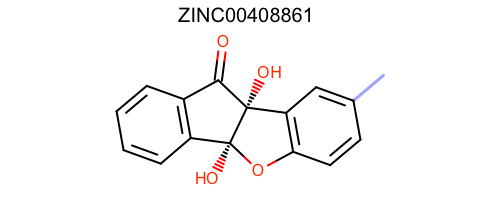

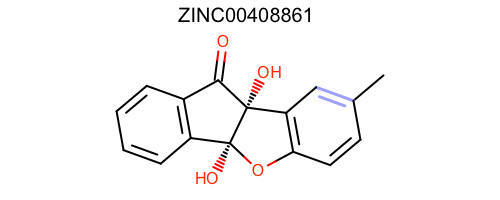

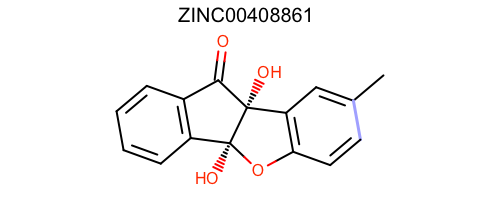

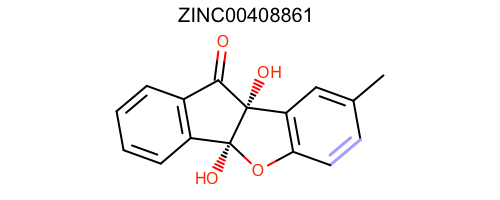

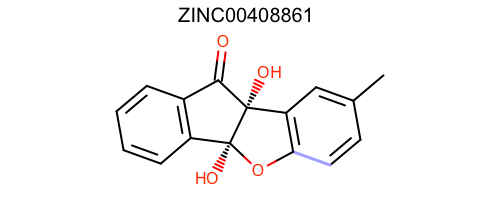

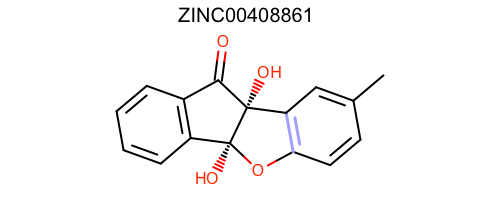

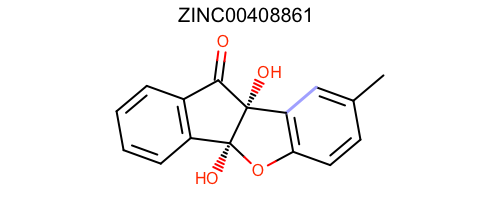

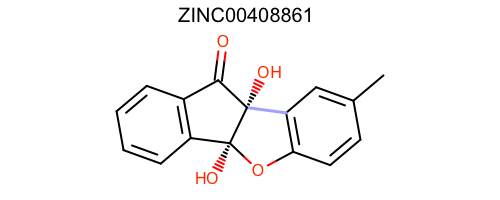

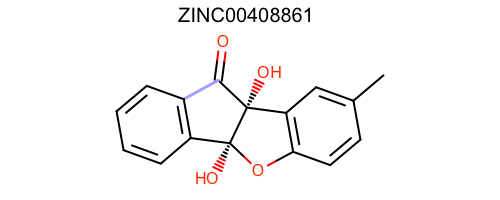

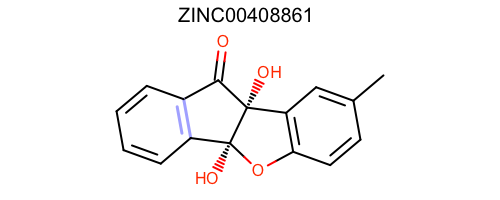

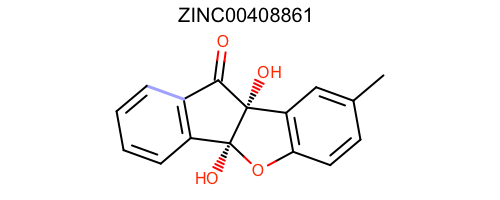

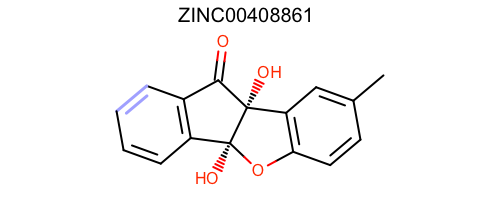

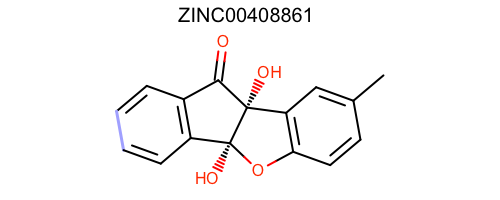

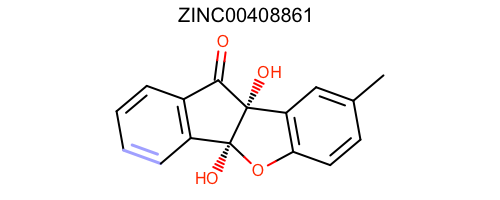

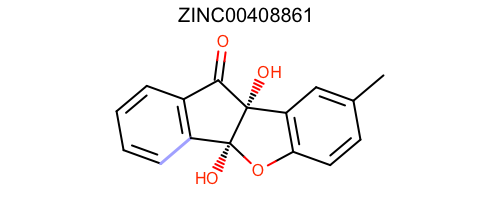

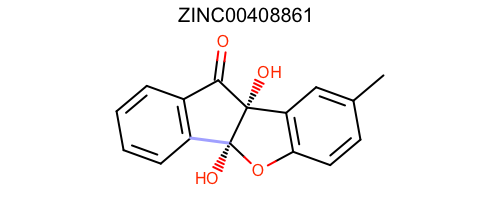

In [7]:
# For demo, pick some SMIRKS which is problematic at least some of the time and show where it appears in the molecule

import openeye.oedepict as oedepict
from IPython.display import display

def depict(mol, width=500, height=200):
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    return Image(data = "".join(ofs.str()))

def depictMatch(mol, match, supH = True, width=500, height=200):
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    hstyle = oedepict.OEHighlightStyle_Color
    hcolor = oechem.OEColor(oechem.OELightBlue)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    #ofs = oechem.oeosstream()
    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img,disp)
    #oedepict.OERenderMolecule(ofs, 'png', disp)
    #ofs.flush()
    #return Image(data = "".join(ofs.str()))
    return Image(oedepict.OEWriteImageToString("png",img))

# Initialize query
qmol = oechem.OEQMol()

# Grab molecule and problematic SMIRKS
mol = oechem.OEMol(oemols_tripos[targetmol])
smirks_list = [k for k in problem_smirks['bond'].keys()]
smirks_list.sort()
smirks=smirks_list[0]
# Prep search
oechem.OEParseSmarts( qmol, smirks)
ss = oechem.OESubSearch(qmol)

# Search molecule, depict
oechem.OEPrepareSearch(mol, ss)
for match in ss.Match(mol, True): #Some torsions may need unique = False
    display( depictMatch(mol, match))
